In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
### Load the csv data
df = pd.read_csv('Data-of-Cervical-Cancer-HPV-16-oncogen-E6-or-E7-with-Cyclin-D1-expression.csv')

### Explore the dataset
print("First 5 rows of the dataset:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nShape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())
print("\nDuplicated rows:", df.duplicated().sum())
print("\nClass Distribution:")
print(df['Immunoreactive Score (IRS) of Cyclin D1'].value_counts())
print("\nMissing values:")
print(df.isnull().sum())

First 5 rows of the dataset:
   Sample Number  HPV positive (%) Category based on percentage  \
0              1                35                            +   
1              2                55                           ++   
2              3                45                            +   
3              4                60                           ++   
4              5                 4                            -   

  Mutation/wild oncogene Oncogene mutation  \
0               Mutation                E6   
1               Mutation                E6   
2                   Wild                 -   
3                   Wild                 -   
4               Mutation                E7   

   Immunoreactive Score (IRS) of Cyclin D1  
0                                        1  
1                                        2  
2                                        1  
3                                        2  
4                                        1  

Columns: ['Sample Nu

In [10]:
### Encode categorical data
df['Category based on percentage'] = df['Category based on percentage'].map({
    '-': 0, '+': 1, '++': 2
})
df['Mutation/wild oncogene'] = df['Mutation/wild oncogene'].map({'Wild': 0, 'Mutation': 1})
df['Oncogene mutation'] = df['Oncogene mutation'].replace('-', 'None')
df['Oncogene mutation'] = df['Oncogene mutation'].map({'None': 0, 'E6': 1, 'E7': 2})
df['Immunoreactive Score (IRS) of Cyclin D1'] = df['Immunoreactive Score (IRS) of Cyclin D1'].map({
    1: 0,  # Weak
    2: 1   # Strong
})

### Define features and target variable
X = df[['HPV positive (%)', 'Category based on percentage', 'Mutation/wild oncogene', 'Oncogene mutation']]
y = df['Immunoreactive Score (IRS) of Cyclin D1']

### Standardize the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

### Split into train and holdout set (90% train+CV, 10% holdout)
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)

In [11]:
### Machine Learning Models with Cross-Validation
ml_models = {
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(),
    'Random Forest': RandomForestClassifier()
}

ml_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in ml_models.items():
    scores = []
    cms = []
    specificity = []
    sensitivity = []
    precision = []
    f1 = []
    auc = []

    print(f"\n{name} Cross-Validation Results:")
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_full, y_train_full)):
        X_train, X_test = X_train_full[train_idx], X_train_full[test_idx]
        y_train, y_test = y_train_full.iloc[train_idx], y_train_full.iloc[test_idx]

        model.fit(X_train, y_train)
        predY = model.predict(X_test)

        cm = confusion_matrix(y_test, predY)
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0
        auc_score = roc_auc_score(y_test, predY)
        accuracy = (predY == y_test).mean() * 100

        scores.append(accuracy)
        cms.append(cm)
        specificity.append(spec * 100)
        sensitivity.append(sens * 100)
        precision.append(prec * 100)
        f1.append(f1_score * 100)
        auc.append(auc_score * 100)

        print(f"Fold {fold + 1}:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Specificity: {spec * 100:.2f}%")
        print(f"Sensitivity: {sens * 100:.2f}%")
        print(f"Precision: {prec * 100:.2f}%")
        print(f"F1 Score: {f1_score * 100:.2f}%")
        print(f"AUC-ROC: {auc_score * 100:.2f}%")

    ml_results[name] = {
        'accuracy_mean': np.mean(scores),
        'accuracy_std': np.std(scores),
        'specificity_mean': np.mean(specificity),
        'sensitivity_mean': np.mean(sensitivity),
        'precision_mean': np.mean(precision),
        'f1_mean': np.mean(f1),
        'auc_mean': np.mean(auc),
        'cms': cms
    }


Logistic Regression Cross-Validation Results:
Fold 1:
Confusion Matrix:
[[4 0]
 [0 2]]
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%
Fold 2:
Confusion Matrix:
[[4 0]
 [0 2]]
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%
Fold 3:
Confusion Matrix:
[[2 1]
 [0 2]]
Accuracy: 80.00%
Specificity: 66.67%
Sensitivity: 100.00%
Precision: 66.67%
F1 Score: 80.00%
AUC-ROC: 83.33%
Fold 4:
Confusion Matrix:
[[3 0]
 [0 2]]
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%
Fold 5:
Confusion Matrix:
[[3 0]
 [0 2]]
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%

SVC Cross-Validation Results:
Fold 1:
Confusion Matrix:
[[4 0]
 [0 2]]
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.0

In [7]:
### Deep Learning Models with Cross-Validation
input_dimension = X_train_full.shape[1]

def get_model(arr, optimizer='adam', activation='relu'):
    model = Sequential()
    for i in range(len(arr)):
        if i == 0:
            model.add(Dense(arr[i], input_dim=input_dimension, activation=activation))
        elif i == len(arr) - 1:
            model.add(Dense(arr[i], activation='sigmoid'))
        else:
            model.add(Dense(arr[i], activation=activation))
            model.add(Dropout(0.2))
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model_configs = [
    ([64, 16, 1], {'activation': 'relu', 'optimizer': 'adam', 'epoch': 100, 'batch': 16}),
    ([128, 64, 16, 1], {'activation': 'relu', 'optimizer': 'adam', 'epoch': 100, 'batch': 16}),
    ([256, 128, 32, 16, 1], {'activation': 'tanh', 'optimizer': 'adagrad', 'epoch': 50, 'batch': 8}),
]

model_names = ['First Model', 'Second Model (Add Layer)', 'Best Config (Tanh+Adagrad)']
dl_results = {}

print("\nDeep Learning Cross-Validation Results:")
for i, (layers, params) in enumerate(model_configs):
    scores = []
    cms = []
    specificity = []
    sensitivity = []
    precision = []
    f1 = []
    auc = []
    histories = []

    print(f"\nTraining {model_names[i]}...")
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_full, y_train_full)):
        X_train, X_test = X_train_full[train_idx], X_train_full[test_idx]
        y_train, y_test = y_train_full.iloc[train_idx], y_train_full.iloc[test_idx]

        model = get_model(layers, params['optimizer'], params['activation'])
        early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=params['epoch'], batch_size=params['batch'],
                           validation_data=(X_test, y_test), class_weight=dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))),
                           callbacks=[early_stopping], verbose=0)
        scores_eval = model.evaluate(X_test, y_test, verbose=0)
        predY = np.round(model.predict(X_test)).astype(int).reshape(-1)

        cm = confusion_matrix(y_test, predY)
        tn, fp, fn, tp = cm.ravel()
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0
        auc_score = roc_auc_score(y_test, predY)
        accuracy = scores_eval[1] * 100

        scores.append(accuracy)
        cms.append(cm)
        specificity.append(spec * 100)
        sensitivity.append(sens * 100)
        precision.append(prec * 100)
        f1.append(f1_score * 100)
        auc.append(auc_score * 100)
        histories.append(history)

        print(f"Fold {fold + 1}:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Loss: {scores_eval[0]:.4f}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Specificity: {spec * 100:.2f}%")
        print(f"Sensitivity: {sens * 100:.2f}%")
        print(f"Precision: {prec * 100:.2f}%")
        print(f"F1 Score: {f1_score * 100:.2f}%")
        print(f"AUC-ROC: {auc_score * 100:.2f}%")

    dl_results[model_names[i]] = {
        'accuracy_mean': np.mean(scores),
        'accuracy_std': np.std(scores),
        'specificity_mean': np.mean(specificity),
        'sensitivity_mean': np.mean(sensitivity),
        'precision_mean': np.mean(precision),
        'f1_mean': np.mean(f1),
        'auc_mean': np.mean(auc),
        'cms': cms,
        'history': histories[0],  # Store history of first fold for plotting
        'model': model  # Store the last trained model for holdout evaluation
    }


Deep Learning Cross-Validation Results:

Training First Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Fold 1:
Confusion Matrix:
[[4 0]
 [0 2]]
Loss: 0.2566
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Fold 2:
Confusion Matrix:
[[4 0]
 [0 2]]
Loss: 0.1273
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Fold 3:
Confusion Matrix:
[[2 1]
 [0 2]]
Loss: 0.8537
Accuracy: 80.00%
Specificity: 66.67%
Sensitivity: 100.00%
Precision: 66.67%
F1 Score: 80.00%
AUC-ROC: 83.33%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Fold 4:
Confusion Matrix:
[[3 0]
 [0 2]]
Loss: 0.1459
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5:
Confusion Matrix:
[[3 0]
 [0 2]]
Loss: 0.1793
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%

Training Second Model (Add Layer)...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1:
Confusion Matrix:
[[4 0]
 [0 2]]
Loss: 0.1159
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Fold 2:
Confusion Matrix:
[[4 0]
 [0 2]]
Loss: 0.0095
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Fold 3:
Confusion Matrix:
[[2 1]
 [0 2]]
Loss: 1.3358
Accuracy: 80.00%
Specificity: 66.67%
Sensitivity: 100.00%
Precision: 66.67%
F1 Score: 80.00%
AUC-ROC: 83.33%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Fold 4:
Confusion Matrix:
[[3 0]
 [0 2]]
Loss: 0.0671
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Fold 5:
Confusion Matrix:
[[3 0]
 [0 2]]
Loss: 0.0610
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%

Training Best Config (Tanh+Adagrad)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Fold 1:
Confusion Matrix:
[[3 1]
 [0 2]]
Loss: 0.3824
Accuracy: 83.33%
Specificity: 75.00%
Sensitivity: 100.00%
Precision: 66.67%
F1 Score: 80.00%
AUC-ROC: 87.50%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Fold 2:
Confusion Matrix:
[[3 1]
 [0 2]]
Loss: 0.3516
Accuracy: 83.33%
Specificity: 75.00%
Sensitivity: 100.00%
Precision: 66.67%
F1 Score: 80.00%
AUC-ROC: 87.50%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Fold 3:
Confusion Matrix:
[[2 1]
 [0 2]]
Loss: 0.6506
Accuracy: 80.00%
Specificity: 66.67%
Sensitivity: 100.00%
Precision: 66.67%
F1 Score: 80.00%
AUC-ROC: 83.33%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Fold 4:
Confusion Matrix:
[[3 0]
 [0 2]]
Loss: 0.2336
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Fold 5:
Confusion Matrix:
[[3 0]
 [0 2]]
Loss: 0.3133
Accuracy: 100.00%
Specificity: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1 Score: 100.00%
AUC-ROC: 100.00%


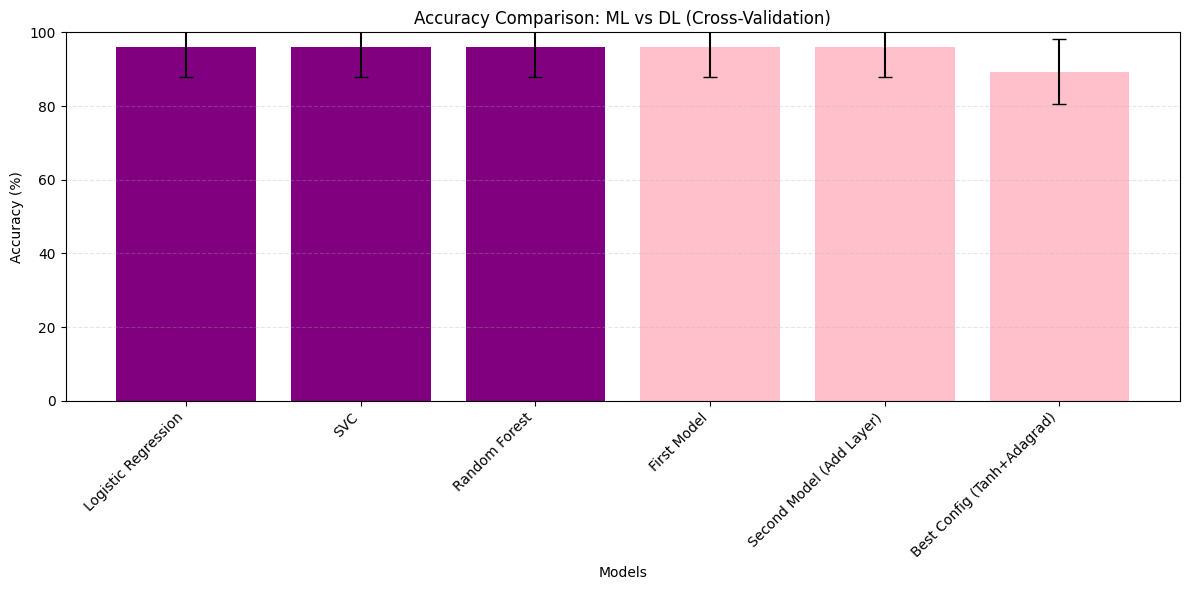

In [12]:
### Comparison Plot: ML vs DL Accuracy
plt.figure(figsize=(12, 6))
models = list(ml_results.keys()) + list(dl_results.keys())
accuracies = [ml_results[name]['accuracy_mean'] for name in ml_results] + [dl_results[name]['accuracy_mean'] for name in dl_results]
errors = [ml_results[name]['accuracy_std'] for name in ml_results] + [dl_results[name]['accuracy_std'] for name in dl_results]
colors = ['purple', 'purple', 'purple', 'pink', 'pink', 'pink']
plt.bar(models, accuracies, yerr=errors, color=colors, capsize=5)
plt.title('Accuracy Comparison: ML vs DL (Cross-Validation)')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

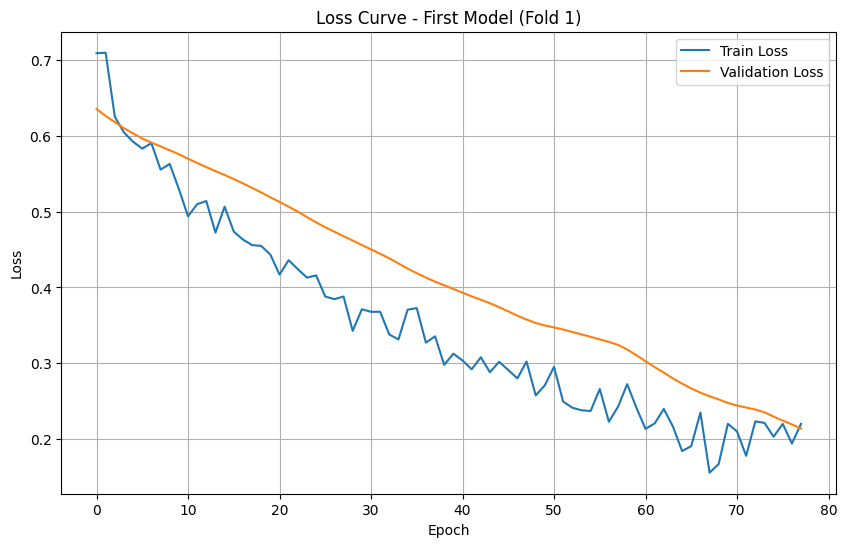

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


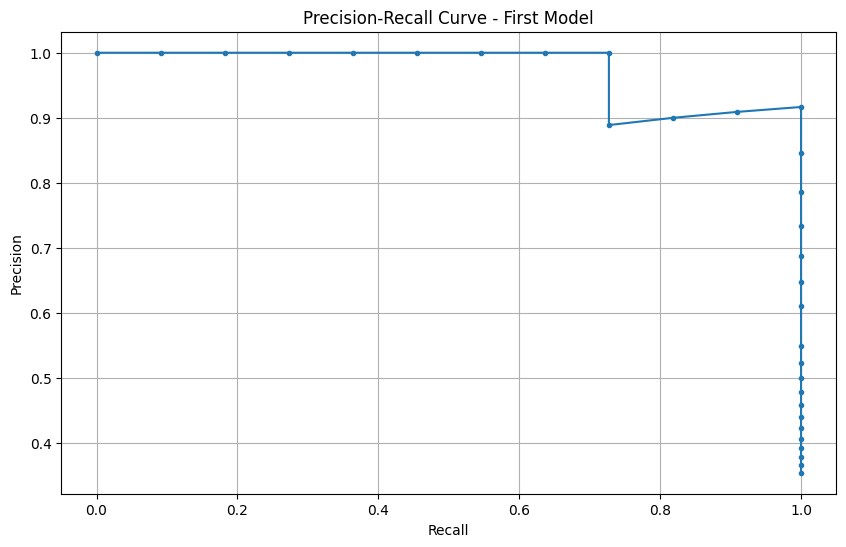

In [13]:
### Plot Loss for Best DL Model (First Fold)
best_dl_name = max(dl_results, key=lambda x: dl_results[x]['accuracy_mean'])
plt.figure(figsize=(10, 6))
plt.plot(dl_results[best_dl_name]['history'].history['loss'], label='Train Loss')
plt.plot(dl_results[best_dl_name]['history'].history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve - {best_dl_name} (Fold 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot Precision-Recall Curve for Best DL Model
pred_proba = dl_results[best_dl_name]['model'].predict(X_scaled)
precision, recall, _ = precision_recall_curve(y, pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve - {best_dl_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [14]:
### Holdout Evaluation
ml_holdout_results = {}
dl_holdout_results = {}

# ML Holdout
for name, model in ml_models.items():
    model.fit(X_train_full, y_train_full)
    predY = model.predict(X_holdout)
    cm = confusion_matrix(y_holdout, predY)
    accuracy = (predY == y_holdout).mean() * 100
    ml_holdout_results[name] = {'cm': cm, 'accuracy': accuracy}

# DL Holdout
for name in model_names:
    model = dl_results[name]['model']
    predY = np.round(model.predict(X_holdout)).astype(int).reshape(-1)
    cm = confusion_matrix(y_holdout, predY)
    accuracy = (predY == y_holdout).mean() * 100
    dl_holdout_results[name] = {'cm': cm, 'accuracy': accuracy}

### Display Results ML
print("\nMachine Learning (Aggregated CV):")
for name in ml_results:
    print(f"\n{name}:")
    print(f"Accuracy: {ml_results[name]['accuracy_mean']:.2f}% (+/- {ml_results[name]['accuracy_std']:.2f}%)")
    print(f"Specificity: {ml_results[name]['specificity_mean']:.2f}%")
    print(f"Sensitivity: {ml_results[name]['sensitivity_mean']:.2f}%")
    print(f"Precision: {ml_results[name]['precision_mean']:.2f}%")
    print(f"F1 Score: {ml_results[name]['f1_mean']:.2f}%")
    print(f"AUC-ROC: {ml_results[name]['auc_mean']:.2f}%")
    print(f"Holdout Confusion Matrix:\n{ml_holdout_results[name]['cm']}")
    print(f"Holdout Accuracy: {ml_holdout_results[name]['accuracy']:.2f}%")

### Display Results DL
print("\nDeep Learning (Aggregated CV):")
for name in dl_results:
    print(f"\n{name}:")
    print(f"Accuracy: {dl_results[name]['accuracy_mean']:.2f}% (+/- {dl_results[name]['accuracy_std']:.2f}%)")
    print(f"Specificity: {dl_results[name]['specificity_mean']:.2f}%")
    print(f"Sensitivity: {dl_results[name]['sensitivity_mean']:.2f}%")
    print(f"Precision: {dl_results[name]['precision_mean']:.2f}%")
    print(f"F1 Score: {dl_results[name]['f1_mean']:.2f}%")
    print(f"AUC-ROC: {dl_results[name]['auc_mean']:.2f}%")
    print(f"Holdout Confusion Matrix:\n{dl_holdout_results[name]['cm']}")
    print(f"Holdout Accuracy: {dl_holdout_results[name]['accuracy']:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Machine Learning (Aggregated CV):

Logistic Regression:
Accuracy: 96.00% (+/- 8.00%)
Specificity: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1 Score: 96.00%
AUC-ROC: 96.67%
Holdout Confusion Matrix:
[[3 0]
 [0 1]]
Holdout Accuracy: 100.00%

SVC:
Accuracy: 96.00% (+/- 8.00%)
Specificity: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1 Score: 96.00%
AUC-ROC: 96.67%
Holdout Confusion Matrix:
[[3 0]
 [0 1]]
Holdout Accuracy: 100.00%

Random Forest:
Accuracy: 96.00% (+/- 8.00%)
Specificity: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1 Score: 96.00%
AUC-ROC: 96.67%
Holdout Confusion Matrix:
[[3 0]
 [0 1]]
Holdout Accuracy: 100.00%

Deep Learning (Aggregated CV):

First Model:
Accuracy: 96.00% (+/- 8.00%)
Specificity: 93.33%
Sensitivity: 100.00%
Precision: 93.33%
F1 Score: 96.00%
AUC-ROC: 96.67%
Holdout Confusion Matrix:
[[3 0]
 [0 1]]
Holdout Accuracy: 100.00%

Second M